# Adding activity chains to synthetic populations 

The purpose of this script is to match each individual in the synthetic population to a respondant from the [National Travel Survey (NTS)](https://beta.ukdataservice.ac.uk/datacatalogue/studies/study?id=5340).

### Methods

We will try two methods

1. categorical matching: joining on relevant socio-demographic variables
2. statistical matching, as described in [An unconstrained statistical matching algorithm for combining individual and household level geo-specific census and survey data](https://doi.org/10.1016/j.compenvurbsys.2016.11.003).

In [2]:
import os
import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import trange

# from tqdm.notebook import trange
from acbm.matching import MatcherExact, match_individuals
from acbm.preprocessing import (
    count_per_group,
    #nts_filter_by_region,
    nts_filter_by_year,
    num_adult_child_hh,
    transform_by_group,
    truncate_values,
)

pd.set_option('display.max_columns', None)

def get_interim_path(file_name: str, path: str="../data/interim/matching/") -> str:
    os.makedirs(path, exist_ok=True)
    return f'{path}/{file_name}'

## Step 1: Load in the datasets  

### SPC 

In [3]:
# useful variables
region = "west-yorkshire"

In [4]:
# Read in the spc data (parquet format)
spc = pd.read_parquet('../data/external/spc_output/' + region + '_people_hh.parquet')
spc.head()

,id,household,workplace,events,weekday_diaries,weekend_diaries,orig_pid,id_tus_hh,id_tus_p,pid_hs,msoa11cd,oa11cd,members,bmi,has_cardiovascular_disease,has_diabetes,has_high_blood_pressure,number_medications,self_assessed_health,life_satisfaction,sic1d2007,sic2d2007,soc2010,pwkstat,salary_yearly,salary_hourly,hid,nssec8,accommodation_type,communal_type,num_rooms,central_heat,tenure,num_cars,sex,age_years,ethnicity,nssec8_household
0,0,0,NaN,"{'concert_f': 1.2791347489984115e-31, 'concert...","[1583, 13161]","[1582, 13160]",E02002183_0001_001,11291218,1,2905399,E02002183,E00053954,[0],24.879356,False,False,False,NaN,3.0,2.0,J,58.0,1115.0,6,NaN,NaN,E02002183_0001,1.0,1.0,NaN,2.0,True,2.0,2,1,86,1,1.0
1,1,1,NaN,"{'concert_f': 9.743248151956307e-21, 'concert_...","[2900, 4948, 4972, 7424, 10284, 10586, 12199, ...","[2901, 4949, 4973, 7425, 10285, 10585, 12198, ...",E02002183_0002_001,17291219,1,2905308,E02002183,E00053953,"[1, 2]",27.491207,False,False,True,NaN,3.0,NaN,C,25.0,1121.0,6,NaN,NaN,E02002183_0002,1.0,3.0,NaN,6.0,True,2.0,2,1,74,3,1.0
2,2,1,NaN,"{'concert_f': 8.46716103992468e-16, 'concert_f...","[3010, 6389, 9448, 10184, 11598]","[3011, 6388, 9447, 10183, 11599]",E02002183_0002_002,17070713,2,2907681,E02002183,E00053953,"[1, 2]",17.310829,False,True,True,NaN,2.0,4.0,P,85.0,2311.0,6,NaN,NaN,E02002183_0002,1.0,3.0,NaN,6.0,True,2.0,2,2,68,1,2.0
3,3,2,56126.0,"{'concert_f': 1.8844366073608398, 'concert_fs'...","[366, 867, 2096, 3678, 5212, 5450, 8145, 9254,...","[365, 868, 2097, 3677, 5213, 5451, 8146, 9253,...",E02002183_0003_001,20310313,1,2902817,E02002183,E00053689,"[3, 4]",20.852091,False,False,False,NaN,2.0,1.0,C,31.0,3422.0,1,32857.859375,14.360952,E02002183_0003,4.0,3.0,NaN,6.0,True,2.0,1,1,27,1,4.0
4,4,2,NaN,"{'concert_f': 4.877435207366943, 'concert_fs':...","[1289, 12528, 12870]","[1288, 12529, 12871]",E02002183_0003_002,13010909,3,2900884,E02002183,E00053689,"[3, 4]",20.032526,False,False,False,1.0,2.0,3.0,J,62.0,7214.0,1,18162.451172,9.439944,E02002183_0003,4.0,3.0,NaN,6.0,True,2.0,1,2,26,1,6.0


In [5]:
# select columns
spc = spc[['id', 'household', 'pid_hs',
       'msoa11cd', 'oa11cd', 'members', 'sic1d2007', 'sic2d2007',
       'pwkstat', 'salary_yearly', 'salary_hourly', 'hid',
       'accommodation_type', 'communal_type', 'num_rooms', 'central_heat',
       'tenure', 'num_cars', 'sex', 'age_years', 'ethnicity', 'nssec8']]

In [6]:
# temporary reduction of the dataset for quick analysis
spc = spc.head(15000)
#spc = spc.head(500000)

### NTS

The NTS is split up into multiple tables. We will load in the following tables:
- individuals
- households
- trips

In [7]:
path_psu = "../data/external/nts/UKDA-5340-tab/tab/psu_eul_2002-2022.tab"
psu = pd.read_csv(path_psu, sep="\t")

#### Individuals

In [8]:
path_individuals = "../data/external/nts/UKDA-5340-tab/tab/individual_eul_2002-2022.tab"
nts_individuals = pd.read_csv(path_individuals,
                              sep="\t",
                              usecols = ['IndividualID',
                                         'HouseholdID',
                                          'PSUID',
                                          'Age_B01ID',
                                          'Age_B04ID',
                                          'Sex_B01ID',
                                          'OfPenAge_B01ID',
                                          'HRPRelation_B01ID',
                                          'EdAttn1_B01ID',
                                          'EdAttn2_B01ID',
                                          'EdAttn3_B01ID',
                                          'OwnCycle_B01ID', # Owns a cycle
                                          'DrivLic_B02ID', # type of driving license
                                          'CarAccess_B01ID',
                                          'IndIncome2002_B02ID',
                                          'IndWkGOR_B02ID', # Region of usual place of work
                                          'EcoStat_B02ID', # Working status of individual
                                          'EcoStat_B03ID',
                                          'NSSec_B03ID', # NSSEC high level breakdown
                                          'SC_B01ID', # Social class of individual
                                          'Stat_B01ID', # employee or self-employed
                                          'WkMode_B01ID', # Usual means of travel to work
                                          'WkHome_B01ID', # Work from home
                                          'PossHom_B01ID', # Is it possible to work from home?
                                          'OftHome_B01ID', # How often work from home
                                          'TravSh_B01ID', # Usual mode from main food shopping trip
                                          'SchDly_B01ID', # Daily school journey?
                                          'SchTrav_B01ID', # Usual mode of travel to school
                                          'SchAcc_B01ID', # IS school trip accompanied by an adult?
                                          'FdShp_B01ID', # How do you usually carry ot main food shop (go to shop, online etc)
                                          ]
)




#### Households

In [9]:
path_households = "../data/external/nts/UKDA-5340-tab/tab/household_eul_2002-2022.tab"
nts_households = pd.read_csv(path_households,
                             sep="\t",
                             usecols = ['HouseholdID',
                                        'PSUID',
                                        'HHIncome2002_B02ID',
                                        'AddressType_B01ID', # type of house
                                        'Ten1_B02ID', # type of tenure
                                        'HHoldNumAdults', # total no. of adults in household
                                        'HHoldNumChildren', # total no. of children in household
                                        'HHoldNumPeople', # total no. of people in household
                                        'NumLicHolders', # total no. of driving license holders in household
                                        'HHoldEmploy_B01ID', # number of employed in household
                                        'NumBike', # no. of bikes
                                        'NumCar', # no. of cars
                                        'NumVanLorry', # no. of vans or lorries
                                        'NumMCycle', # no. of motorcycles
                                        'WalkBus_B01ID', # walk time from house to nearest bus stop
                                        'Getbus_B01ID', # frequency of bus service
                                        'WalkRail_B01ID', # walk time from house to nearest rail station
                                        'JTimeHosp_B01ID', # journey time to nearest hospital
                                        'DVShop_B01ID', # person no. for main food shooper in hh
                                        'Settlement2011EW_B03ID', # ONS Urban/Rural: 2 categories
                                        'Settlement2011EW_B04ID', # ONS Urban/Rural: 3 categories
                                        'HHoldOAClass2011_B03ID', # Census 2011 OA Classification
                                        'HRPWorkStat_B02ID', # HH ref person working status
                                        'HRPSEGWorkStat_B01ID', #  HH ref person socio economic group for active workers
                                        'W0', # Unweighted interview sample
                                        'W1', # Unweighted diary sample
                                        'W2', # Weighted diary sample
                                        'W3', # Weighted interview sample
                                        ]
  )

#### Trips

In [10]:

path_trips = "../data/external/nts/UKDA-5340-tab/tab/trip_eul_2002-2022.tab"
nts_trips = pd.read_csv(path_trips,
                        sep="\t",
                        usecols = ['TripID',
                                   'DayID',
                                   'IndividualID',
                                   'HouseholdID',
                                   'PSUID',
                                   'PersNo',
                                   'TravDay',
                                   'JourSeq',
                                   'ShortWalkTrip_B01ID',
                                   'NumStages',
                                   'MainMode_B03ID',
                                   'MainMode_B04ID',
                                   'TripPurpFrom_B01ID',
                                   'TripPurpTo_B01ID',
                                   'TripPurpose_B04ID',
                                   'TripStart',
                                   'TripEnd',
                                   'TripTotalTime',
                                   'TripTravTime',
                                   'TripDisIncSW',
                                   'TripDisExSW',
                                   'TripOrigGOR_B02ID',
                                   'TripDestGOR_B02ID',
                                   'W5',
                                   'W5xHH'
                        ]
    )


#### Filter by year

We will filter the NTS data to only include data from specific years. We can choose only 1 year, or multiple years to increase our sample size and the likelihood of a match with the spc

In [11]:
years = [2019, 2021, 2022]

nts_individuals = nts_filter_by_year(nts_individuals, psu, years)
nts_households = nts_filter_by_year(nts_households, psu, years)
nts_trips = nts_filter_by_year(nts_trips, psu, years)



#### Filter by geography 

I will not do this for categorical matching, as it reduces the sample significantly, and leads to more spc households not being matched

In [12]:
# regions = ['Yorkshire and the Humber', 'North West']

# nts_individuals = nts_filter_by_region(nts_individuals, psu, regions)
# nts_households = nts_filter_by_region(nts_households, psu, regions)
# nts_trips = nts_filter_by_region(nts_trips, psu, regions)


Create dictionaries of key value pairs

In [13]:
'''
guide to the dictionaries:

_nts_hh: from NTS households table
_nts_ind: from NTS individuals table
_spc: from SPC

'''


# ---------- NTS

# Create a dictionary for the HHIncome2002_B02ID column
income_dict_nts_hh = {
     '1': '0-25k',
     '2': '25k-50k',
     '3': '50k+',
    '-8': 'NA',
    # should be -10, but
    # it could be a typo in household_eul_2002-2022_ukda_data_dictionary
    '-1': 'DEAD'
}

# Create a dictionary for the HHoldEmploy_B01ID column
# (PT: Part time, FT: Full time)
employment_dict_nts_hh = {
    '1': 'None',
    '2': '0 FT, 1 PT',
    '3': '1 FT, 0 PT',
    '4': '0 FT, 2 PT',
    '5': '1 FT, 1 PT',
    '6': '2 FT, 0 PT',
    '7': '1 FT, 2+ PT',
    '8': '2 FT, 1+ PT',
    '9': '0 FT, 3+ PT',
    '10': '3+ FT, 0 PT',
    '11': '3+ FT, 1+ PT',
    '-8': 'NA',
    '-10': 'DEAD'
}

# Create a dictionary for the Ten1_B02ID column
tenure_dict_nts_hh = {
    '1': 'Owns / buying',
    '2': 'Rents',
    '3': 'Other (including rent free)',
    '-8': 'NA',
    '-9': 'DNA',
    '-10': 'DEAD'
}


# ---------- SPC


# create a dictionary for the pwkstat column
employment_dict_spc = {
    '0': 'Not applicable (age < 16)',
    '1': 'Employee FT',
    '2': 'Employee PT',
    '3': 'Employee unspecified',
    '4': 'Self-employed',
    '5': 'Unemployed',
    '6': 'Retired',
    '7': 'Homemaker/Maternal leave',
    '8': 'Student',
    '9': 'Long term sickness/disability',
    '10': 'Other'
}


# Create a dictionary for the tenure column
tenure_dict_spc = {
    '1': 'Owned: Owned outright',
    '2': 'Owned: Owned with a mortgage or loan or shared ownership',
    '3': 'Rented or living rent free: Total',
    '4': 'Rented: Social rented',
    '5': 'Rented: Private rented or living rent free',
    '-8': 'NA',
    '-9': 'DNA',
    '-10': 'DEAD'
}


# Combine the dictionaries into a dictionary of dictionaries

dict_nts = {
    'HHIncome2002_B02ID': income_dict_nts_hh,
    'HHoldEmploy_B01ID': employment_dict_nts_hh,
    'Ten1_B02ID': tenure_dict_nts_hh
}

dict_spc = {
    'pwkstat': employment_dict_spc,
    'tenure': tenure_dict_spc
}



## Step 2: Decide on matching variables  

We need to identify the socio-demographic characteristics that we will match on. The schema for the synthetic population can be found [here](https://github.com/alan-turing-institute/uatk-spc/blob/main/synthpop.proto). 

Matching between the SPC and the NTS will happen in two steps: 

1. Match at the household level
2. Match individuals within the household

### Household level matching 

| Variable           | Name (NTS)           | Name (SPC)      | Transformation (NTS) | Transformation (SPC) |
| ------------------ | -------------------- | --------------- | -------------------- | -------------------- |
| Household income   | `HHIncome2002_BO2ID` | `salary_yearly` | NA                   | Group by household ID and sum |
| Number of adults   | `HHoldNumAdults`        | `age_years`     | NA                   | Group by household ID and count |
| Number of children | `HHoldNumChildren`      | `age_years`     | NA                   | Group by household ID and count |
| Employment status  | `HHoldEmploy_B01ID`  | `pwkstat`       | NA                   | a) match to NTS categories. b) group by household ID |
| Car ownership      | `NumCar`             | `num_cars`      | SPC is capped at 2. We change all entries > 2 to 2 | NA  |

Other columns to match in the future
| Variable           | Name (NTS)           | Name (SPC)      | Transformation (NTS) | Transformation (SPC) |
| ------------------ | -------------------- | --------------- | -------------------- | -------------------- |
| Type of tenancy    | `Ten1_B02ID`         | `tenure`        | ?? | ?? |
|  Urban-Rural classification of residence | `Settlement2011EW_B04ID`         | NA     | NA            | Spatial join between [layer](https://www.gov.uk/government/collections/rural-urban-classification) and SPC  |



### 2.1 Edit SPC columns 

#### Household Income

Edit the spc so that we have household income as well as individual income.

In [14]:
# add household income column for SPC
spc_edited = transform_by_group(data = spc,
                                group_col = 'household',
                                transform_col = 'salary_yearly',
                                new_col = 'salary_yearly_hh',
                                transformation_type = 'sum')


Check number of individuals and households with reported salaries

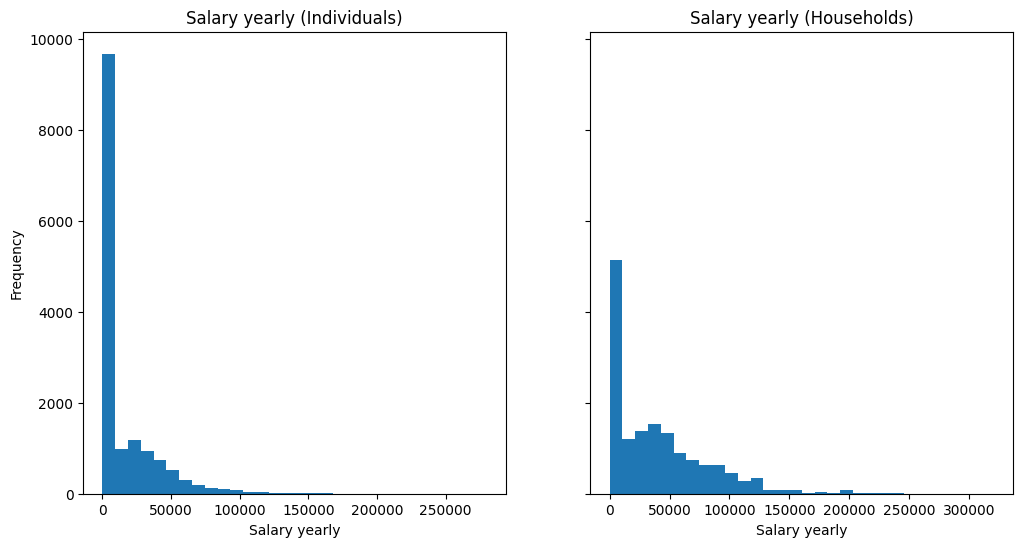

Individuals in SPC = 15000
Individuals without reported income = 9226
% of individuals with reported income = 38.5
Individuals with reported income: 0 = 0
Households in SPC = 6725
Households without reported income = 4605
% of households with reported income = 68.5
Households with reported income: 0 = 4605


In [15]:
# histogram for individuals and households (include NAs as 0)
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
ax[0].hist(spc_edited['salary_yearly'].fillna(0), bins=30)
ax[0].set_title('Salary yearly (Individuals)')
ax[0].set_xlabel('Salary yearly')
ax[0].set_ylabel('Frequency')
ax[1].hist(spc_edited['salary_yearly_hh'].fillna(0), bins=30)
ax[1].set_title('Salary yearly (Households)')
ax[1].set_xlabel('Salary yearly')
plt.show()


# statistics

# print the total number of rows in the spc. Add a message "Values ="
print("Individuals in SPC =", spc_edited.shape[0])
# number of individuals without reported income
print("Individuals without reported income =", spc_edited['salary_yearly'].isna().sum())
# % of individuals with reported income (salary_yearly not equal NA)
print("% of individuals with reported income =", round((spc_edited['salary_yearly'].count() / spc_edited.shape[0]) * 100, 1))
print("Individuals with reported income: 0 =", spc_edited[spc_edited['salary_yearly'] == 0].shape[0])


# print the total number of households
print("Households in SPC =", spc_edited['household'].nunique())
# number of households without reported income (salary yearly_hh = 0)
print("Households without reported income =", spc_edited[spc_edited['salary_yearly_hh'] == 0].shape[0])
# # % of households with reported income (salary_yearly not equal NA)
print("% of households with reported income =", round((spc_edited[spc_edited['salary_yearly_hh'] == 0].shape[0] / spc_edited['household'].nunique()) * 100, 1))
print("Households with reported income: 0 =", spc_edited[spc_edited['salary_yearly_hh'] == 0].shape[0])


In [16]:
# --- Recode column so that it matches the reported NTS values (Use income_dict_nts_hh dictionary for reference)

# Define the bins (first )
bins = [0, 24999, 49999, np.inf]
# Define the labels for the bins
labels = [1, 2, 3]

spc_edited = spc_edited.copy()

spc_edited['salary_yearly_hh_cat'] = (pd.cut(spc_edited['salary_yearly_hh'], bins=bins, labels=labels, include_lowest=True)
                                       .astype('str')
                                       .astype('float'))


# replace NA values with -8 (to be consistent with NTS)
spc_edited['salary_yearly_hh_cat'] = spc_edited['salary_yearly_hh_cat'].fillna(-8)

# Convert the column to int
spc_edited['salary_yearly_hh_cat'] = spc_edited['salary_yearly_hh_cat'].astype('int')

If we compare household income from the SPC and the NTS, we find that the SPC has many more households with no reported income (-8). This will create an issue when matching using household income

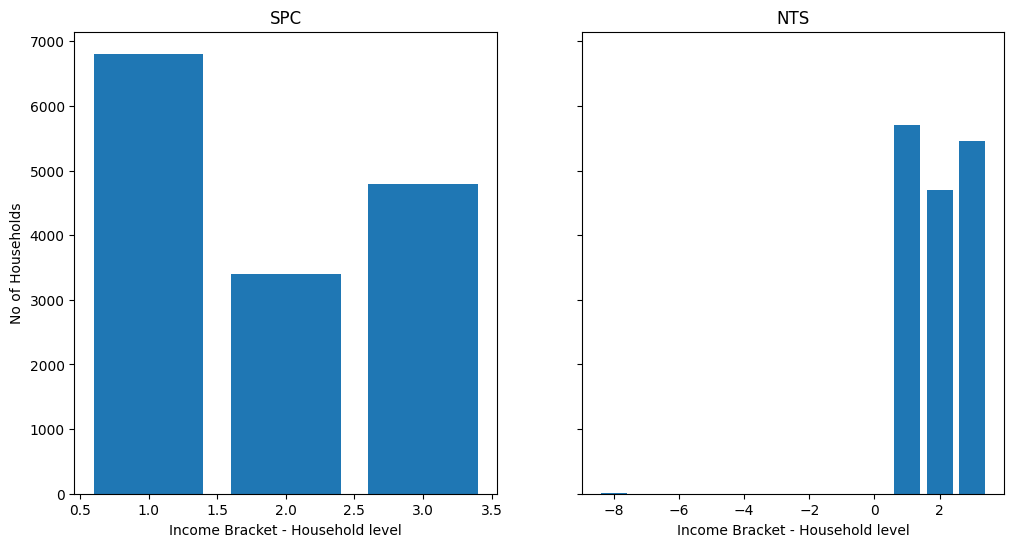

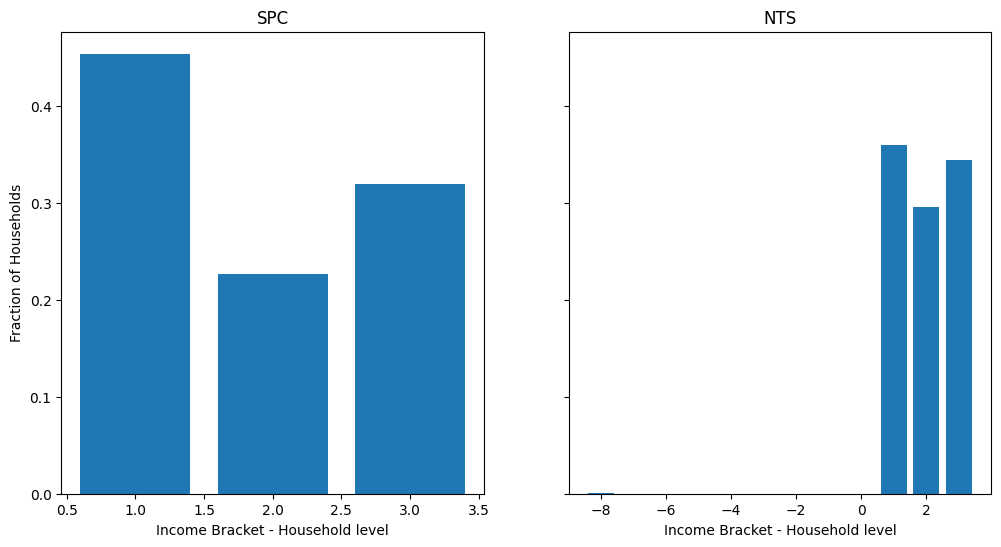

In [17]:
# bar plot showing spc_edited.salary_yearly_hh_cat and nts_households.HHIncome2002_B02ID side by side
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
ax[0].bar(spc_edited['salary_yearly_hh_cat'].value_counts().index, spc_edited['salary_yearly_hh_cat'].value_counts().values)
ax[0].set_title('SPC')
ax[0].set_xlabel('Income Bracket - Household level')
ax[0].set_ylabel('No of Households')
ax[1].bar(nts_households['HHIncome2002_B02ID'].value_counts().index, nts_households['HHIncome2002_B02ID'].value_counts().values)
ax[1].set_title('NTS')
ax[1].set_xlabel('Income Bracket - Household level')
plt.show()

# same as above but (%)
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
ax[0].bar(spc_edited['salary_yearly_hh_cat'].value_counts(normalize=True).index, spc_edited['salary_yearly_hh_cat'].value_counts(normalize=True).values)
ax[0].set_title('SPC')
ax[0].set_xlabel('Income Bracket - Household level')
ax[0].set_ylabel('Fraction of Households')
ax[1].bar(nts_households['HHIncome2002_B02ID'].value_counts(normalize=True).index, nts_households['HHIncome2002_B02ID'].value_counts(normalize=True).values)
ax[1].set_title('NTS')
ax[1].set_xlabel('Income Bracket - Household level')
plt.show()

In [18]:
# get the % of households in each income bracket for the nts
nts_households['HHIncome2002_B02ID'].value_counts(normalize=True) * 100

HHIncome2002_B02ID
 1.0    35.969773
 3.0    34.382872
 2.0    29.559194
-8.0     0.088161
Name: proportion, dtype: float64

#### Household Composition (No. of Adults / Children)

In [19]:
# Number of adults and children in the household

spc_edited = num_adult_child_hh(data = spc_edited,
                                group_col = 'household',
                                age_col = 'age_years')

#### Employment Status

In [20]:
# Employment status

# check the colums values from our dictionary
dict_spc['pwkstat'], dict_nts['HHoldEmploy_B01ID']

({'0': 'Not applicable (age < 16)',
  '1': 'Employee FT',
  '2': 'Employee PT',
  '3': 'Employee unspecified',
  '4': 'Self-employed',
  '5': 'Unemployed',
  '6': 'Retired',
  '7': 'Homemaker/Maternal leave',
  '8': 'Student',
  '9': 'Long term sickness/disability',
  '10': 'Other'},
 {'1': 'None',
  '2': '0 FT, 1 PT',
  '3': '1 FT, 0 PT',
  '4': '0 FT, 2 PT',
  '5': '1 FT, 1 PT',
  '6': '2 FT, 0 PT',
  '7': '1 FT, 2+ PT',
  '8': '2 FT, 1+ PT',
  '9': '0 FT, 3+ PT',
  '10': '3+ FT, 0 PT',
  '11': '3+ FT, 1+ PT',
  '-8': 'NA',
  '-10': 'DEAD'})

The NTS only reports the number of Full time and Part time employees for each household. For the SPC we also need to get the number of full time and part time workers for each household.

Step 1: Create a column for Full time and a column for Part time

In [21]:
# We will only use '1' and '2' for the employment status

counts_df = count_per_group(df = spc_edited,
                            group_col = 'household',
                            count_col = 'pwkstat',
                            values=[1, 2],
                            value_names=['pwkstat_FT_hh','pwkstat_PT_hh'])

counts_df.head(10)

,pwkstat_FT_hh,pwkstat_PT_hh
household,,
0,0,0
1,0,0
2,2,0
3,1,0
4,0,0
5,1,0
6,0,0
7,1,0
8,1,0


Create a column that matches the NTS categories (m FT, n PT)

In [22]:
# We want to match the SPC values to the NTS
dict_nts['HHoldEmploy_B01ID']
'''
{
    '1': 'None',
    '2': '0 FT, 1 PT',
    '3': '1 FT, 0 PT',
    '4': '0 FT, 2 PT',
    '5': '1 FT, 1 PT',
    '6': '2 FT, 0 PT',
    '7': '1 FT, 2+ PT',
    '8': '2 FT, 1+ PT',
    '9': '0 FT, 3+ PT',
    '10': '3+ FT, 0 PT',
    '11': '3+ FT, 1+ PT',
    '-8': 'NA',
    '-10': 'DEAD'}
 '''

# 1) Match each row to the NTS

# Define the conditions and outputs.
# We are using the keys in dict_nts['HHoldEmploy_B01ID'] as reference
conditions = [
    (counts_df['pwkstat_FT_hh'] == 0) & (counts_df['pwkstat_PT_hh'] == 0),
    (counts_df['pwkstat_FT_hh'] == 0) & (counts_df['pwkstat_PT_hh'] == 1),
    (counts_df['pwkstat_FT_hh'] == 1) & (counts_df['pwkstat_PT_hh'] == 0),
    (counts_df['pwkstat_FT_hh'] == 0) & (counts_df['pwkstat_PT_hh'] == 2),
    (counts_df['pwkstat_FT_hh'] == 1) & (counts_df['pwkstat_PT_hh'] == 1),
    (counts_df['pwkstat_FT_hh'] == 2) & (counts_df['pwkstat_PT_hh'] == 0),
    (counts_df['pwkstat_FT_hh'] == 1) & (counts_df['pwkstat_PT_hh'] >= 2),
    (counts_df['pwkstat_FT_hh'] == 2) & (counts_df['pwkstat_PT_hh'] >= 1),
    (counts_df['pwkstat_FT_hh'] == 0) & (counts_df['pwkstat_PT_hh'] >= 3),
    (counts_df['pwkstat_FT_hh'] >= 3) & (counts_df['pwkstat_PT_hh'] == 0),
    (counts_df['pwkstat_FT_hh'] >= 3) & (counts_df['pwkstat_PT_hh'] >= 1)
]

# Define the corresponding outputs based on dict_nts['HHoldEmploy_B01ID]
outputs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

# Create a new column using np.select
counts_df['pwkstat_NTS_match'] = np.select(conditions,
                                           outputs,
                                           default= -8)



# 2) merge back onto the spc
spc_edited = spc_edited.merge(counts_df, left_on='household', right_index=True)

# check the output
spc_edited[['household', 'pwkstat', 'pwkstat_FT_hh', 'pwkstat_PT_hh', 'pwkstat_NTS_match']].head(10)


,household,pwkstat,pwkstat_FT_hh,pwkstat_PT_hh,pwkstat_NTS_match
0,0,6,0,0,1
1,1,6,0,0,1
2,1,6,0,0,1
3,2,1,2,0,6
4,2,1,2,0,6
5,3,1,1,0,3
6,4,10,0,0,1
7,4,4,0,0,1
8,4,0,0,0,1
9,5,1,1,0,3


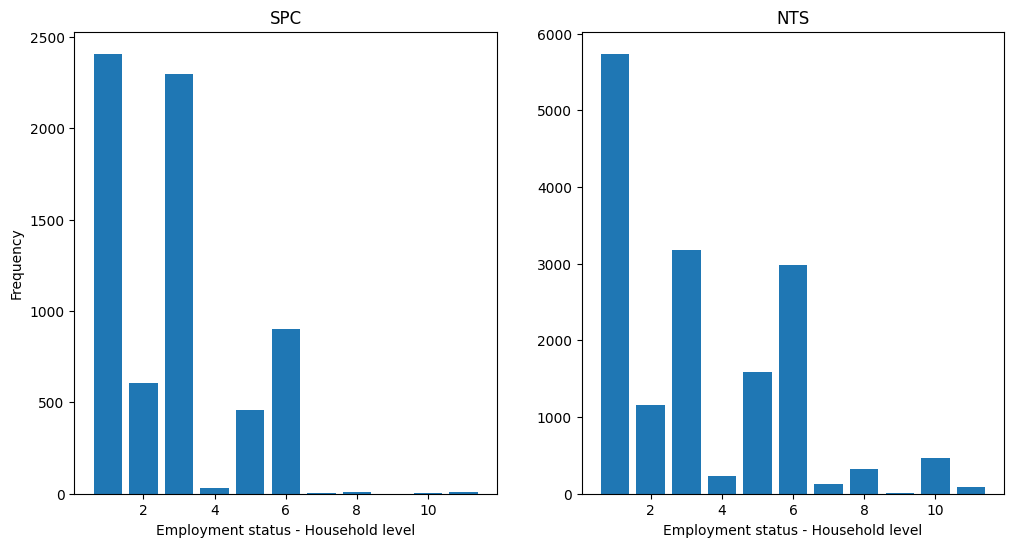

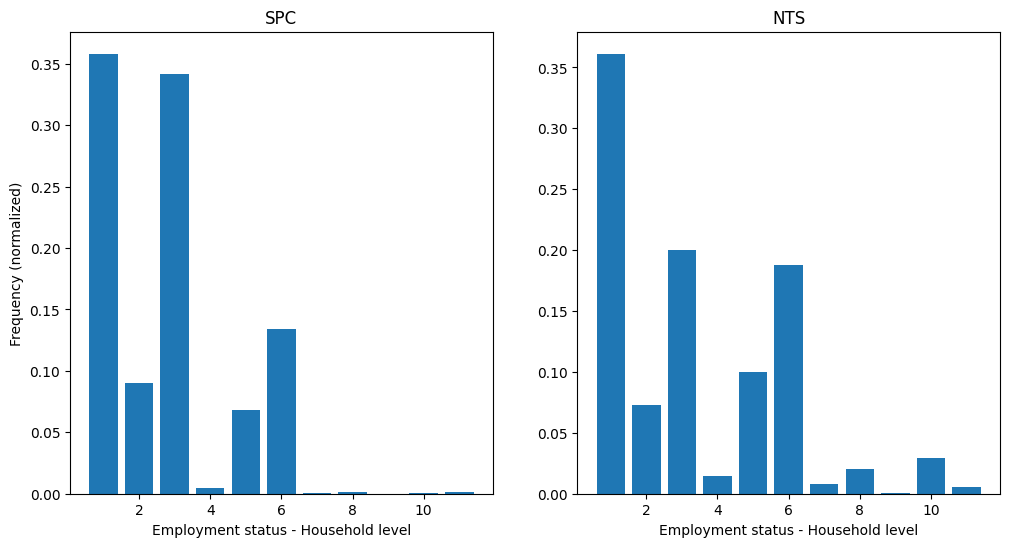

In [23]:
# bar plot of counts_df['pwkstat_NTS_match'] and nts_households['HHoldEmploy_B01ID']
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].bar(counts_df['pwkstat_NTS_match'].value_counts().index, counts_df['pwkstat_NTS_match'].value_counts().values)
ax[0].set_title('SPC')
ax[0].set_xlabel('Employment status - Household level')
ax[0].set_ylabel('Frequency')
ax[1].bar(nts_households['HHoldEmploy_B01ID'].value_counts().index, nts_households['HHoldEmploy_B01ID'].value_counts().values)
ax[1].set_title('NTS')
ax[1].set_xlabel('Employment status - Household level')
plt.show()

# same as above but percentages
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].bar(counts_df['pwkstat_NTS_match'].value_counts().index, counts_df['pwkstat_NTS_match'].value_counts(normalize=True).values)
ax[0].set_title('SPC')
ax[0].set_xlabel('Employment status - Household level')
ax[0].set_ylabel('Frequency (normalized)')
ax[1].bar(nts_households['HHoldEmploy_B01ID'].value_counts().index, nts_households['HHoldEmploy_B01ID'].value_counts(normalize=True).values)
ax[1].set_title('NTS')
ax[1].set_xlabel('Employment status - Household level')
plt.show()



#### Urban Rural Classification

We use the 2011 rural urban classification to match the SPC to the NTS. The NTS has 2 columns that we can use to match to the SPC: `Settlement2011EW_B03ID` and `Settlement2011EW_B04ID`. The `Settlement2011EW_B03ID` column is more general (urban / rural only), while the `Settlement2011EW_B04ID` column is more specific. We stick to the more general column for now.

In [24]:
# read the rural urban classification data
rural_urban = pd.read_csv('../data/external/census_2011_rural_urban.csv', sep=',')

# merge the rural_urban data with the spc
spc_edited = spc_edited.merge(rural_urban[['OA11CD', 'RUC11', 'RUC11CD']], left_on='oa11cd', right_on='OA11CD')
spc_edited.head(5)



,id,household,pid_hs,msoa11cd,oa11cd,members,sic1d2007,sic2d2007,pwkstat,salary_yearly,salary_hourly,hid,accommodation_type,communal_type,num_rooms,central_heat,tenure,num_cars,sex,age_years,ethnicity,nssec8,salary_yearly_hh,salary_yearly_hh_cat,is_adult,num_adults,is_child,num_children,is_pension_age,num_pension_age,pwkstat_FT_hh,pwkstat_PT_hh,pwkstat_NTS_match,OA11CD,RUC11,RUC11CD
0,0,0,2905399,E02002183,E00053954,[0],J,58.0,6,NaN,NaN,E02002183_0001,1.0,NaN,2.0,True,2.0,2,1,86,1,1.0,0.000000,1,1,1,0,0,1,1,0,0,1,E00053954,Urban city and town,C1
1,1,1,2905308,E02002183,E00053953,"[1, 2]",C,25.0,6,NaN,NaN,E02002183_0002,3.0,NaN,6.0,True,2.0,2,1,74,3,1.0,0.000000,1,1,2,0,0,1,2,0,0,1,E00053953,Urban city and town,C1
2,2,1,2907681,E02002183,E00053953,"[1, 2]",P,85.0,6,NaN,NaN,E02002183_0002,3.0,NaN,6.0,True,2.0,2,2,68,1,1.0,0.000000,1,1,2,0,0,1,2,0,0,1,E00053953,Urban city and town,C1
3,3,2,2902817,E02002183,E00053689,"[3, 4]",C,31.0,1,32857.859375,14.360952,E02002183_0003,3.0,NaN,6.0,True,2.0,1,1,27,1,4.0,51020.310547,3,1,2,0,0,0,0,2,0,6,E00053689,Rural town and fringe,D1
4,4,2,2900884,E02002183,E00053689,"[3, 4]",J,62.0,1,18162.451172,9.439944,E02002183_0003,3.0,NaN,6.0,True,2.0,1,2,26,1,4.0,51020.310547,3,1,2,0,0,0,0,2,0,6,E00053689,Rural town and fringe,D1


In [25]:
# create dictionary from the NTS `Settlement2011EW_B03ID` column
Settlement2011EW_B03ID_nts_hh = {
    '1': 'Urban',
    '2': 'Rural',
    '3': 'Scotland',
    '-8': 'NA',
    '-10': 'DEAD'
}

Settlement2011EW_B04ID_nts_hh = {
    '1': 'Urban Conurbation',
    '2': 'Urban City and Town',
    '3': 'Rural Town and Fringe',
    '4': 'Rural Village, Hamlet and Isolated Dwellings',
    '5': 'Scotland',
    '-8': 'NA',
    '-10': 'DEAD'
}


census_2011_to_nts_B03ID = {
    'Urban major conurbation': 'Urban',
    'Urban minor conurbation': 'Urban',
    'Urban city and town': 'Urban',
    'Urban city and town in a sparse setting': 'Urban',
    'Rural town and fringe': 'Rural',
    'Rural town and fringe in a sparse setting': 'Rural',
    'Rural village': 'Rural',
    'Rural village in a sparse setting': 'Rural',
    'Rural hamlets and isolated dwellings': 'Rural',
    'Rural hamlets and isolated dwellings in a sparse setting': 'Rural'
}

census_2011_to_nts_B04ID = {
    'Urban major conurbation': 'Urban Conurbation',
    'Urban minor conurbation': 'Urban Conurbation',
    'Urban city and town': 'Urban City and Town',
    'Urban city and town in a sparse setting': 'Urban City and Town',
    'Rural town and fringe': 'Rural Town and Fringe',
    'Rural town and fringe in a sparse setting': 'Rural Town and Fringe',
    'Rural village': 'Rural Village, Hamlet and Isolated Dwellings',
    'Rural village in a sparse setting': 'Rural Village, Hamlet and Isolated Dwellings',
    'Rural hamlets and isolated dwellings': 'Rural Village, Hamlet and Isolated Dwellings',
    'Rural hamlets and isolated dwellings in a sparse setting': 'Rural Village, Hamlet and Isolated Dwellings'
}


In [26]:
# add the nts Settlement2011EW_B03ID and Settlement2011EW_B04ID columns to the spc
spc_edited['Settlement2011EW_B03ID_spc'] = spc_edited['RUC11'].map(census_2011_to_nts_B03ID)
spc_edited['Settlement2011EW_B04ID_spc'] = spc_edited['RUC11'].map(census_2011_to_nts_B04ID)
spc_edited.head()

# add the keys from nts_Settlement2011EW_B03ID and nts_Settlement2011EW_B04ID to the spc based on above mappings

# reverse the dictionaries
Settlement2011EW_B03ID_nts_rev = {v: k for k, v in Settlement2011EW_B03ID_nts_hh.items()}
# map the values
spc_edited['Settlement2011EW_B03ID_spc_CD'] = spc_edited['Settlement2011EW_B03ID_spc'].map(Settlement2011EW_B03ID_nts_rev).astype('int')

Settlement2011EW_B04ID_nts_rev = {v: k for k, v in Settlement2011EW_B04ID_nts_hh.items()}
spc_edited['Settlement2011EW_B04ID_spc_CD'] = spc_edited['Settlement2011EW_B04ID_spc'].map(Settlement2011EW_B04ID_nts_rev).astype('int')
spc_edited.head()

,id,household,pid_hs,msoa11cd,oa11cd,members,sic1d2007,sic2d2007,pwkstat,salary_yearly,salary_hourly,hid,accommodation_type,communal_type,num_rooms,central_heat,tenure,num_cars,sex,age_years,ethnicity,nssec8,salary_yearly_hh,salary_yearly_hh_cat,is_adult,num_adults,is_child,num_children,is_pension_age,num_pension_age,pwkstat_FT_hh,pwkstat_PT_hh,pwkstat_NTS_match,OA11CD,RUC11,RUC11CD,Settlement2011EW_B03ID_spc,Settlement2011EW_B04ID_spc,Settlement2011EW_B03ID_spc_CD,Settlement2011EW_B04ID_spc_CD
0,0,0,2905399,E02002183,E00053954,[0],J,58.0,6,NaN,NaN,E02002183_0001,1.0,NaN,2.0,True,2.0,2,1,86,1,1.0,0.000000,1,1,1,0,0,1,1,0,0,1,E00053954,Urban city and town,C1,Urban,Urban City and Town,1,2
1,1,1,2905308,E02002183,E00053953,"[1, 2]",C,25.0,6,NaN,NaN,E02002183_0002,3.0,NaN,6.0,True,2.0,2,1,74,3,1.0,0.000000,1,1,2,0,0,1,2,0,0,1,E00053953,Urban city and town,C1,Urban,Urban City and Town,1,2
2,2,1,2907681,E02002183,E00053953,"[1, 2]",P,85.0,6,NaN,NaN,E02002183_0002,3.0,NaN,6.0,True,2.0,2,2,68,1,1.0,0.000000,1,1,2,0,0,1,2,0,0,1,E00053953,Urban city and town,C1,Urban,Urban City and Town,1,2
3,3,2,2902817,E02002183,E00053689,"[3, 4]",C,31.0,1,32857.859375,14.360952,E02002183_0003,3.0,NaN,6.0,True,2.0,1,1,27,1,4.0,51020.310547,3,1,2,0,0,0,0,2,0,6,E00053689,Rural town and fringe,D1,Rural,Rural Town and Fringe,2,3
4,4,2,2900884,E02002183,E00053689,"[3, 4]",J,62.0,1,18162.451172,9.439944,E02002183_0003,3.0,NaN,6.0,True,2.0,1,2,26,1,4.0,51020.310547,3,1,2,0,0,0,0,2,0,6,E00053689,Rural town and fringe,D1,Rural,Rural Town and Fringe,2,3


### 2.2 Edit NTS columns

#### Number of people of pension age

In [27]:
nts_pensioners = count_per_group(df = nts_individuals,
                                 group_col='HouseholdID',
                                 count_col='OfPenAge_B01ID',
                                 values=[1],
                                 value_names=['num_pension_age_nts'])

nts_pensioners.head()

# join onto the nts household df
nts_households = nts_households.merge(nts_pensioners, left_on='HouseholdID', right_index=True, how='left')

#### Number of cars

- `SPC.num_cars` only has values [0, 1, 2]. 2 is for all households with 2 or more cars
- `NTS.NumCar` is more detailed. It has the actual value of the number of cars. We will cap this at 2.

In [28]:

# Create a new column in NTS
nts_households.loc[:, 'NumCar_SPC_match'] = nts_households['NumCar'].apply(truncate_values, upper = 2)

nts_households[['NumCar', 'NumCar_SPC_match']].head(20)

,NumCar,NumCar_SPC_match
142954,1.0,1.0
142955,1.0,1.0
142956,0.0,0.0
142957,2.0,2.0
142958,1.0,1.0
142959,1.0,1.0
142960,2.0,2.0
142961,1.0,1.0
142962,2.0,2.0
142963,1.0,1.0


#### Type of tenancy

Breakdown between NTS and SPC is different. 

In [29]:
dict_nts['Ten1_B02ID'], dict_spc['tenure']

({'1': 'Owns / buying',
  '2': 'Rents',
  '3': 'Other (including rent free)',
  '-8': 'NA',
  '-9': 'DNA',
  '-10': 'DEAD'},
 {'1': 'Owned: Owned outright',
  '2': 'Owned: Owned with a mortgage or loan or shared ownership',
  '3': 'Rented or living rent free: Total',
  '4': 'Rented: Social rented',
  '5': 'Rented: Private rented or living rent free',
  '-8': 'NA',
  '-9': 'DNA',
  '-10': 'DEAD'})

Create dictionaries to map tenure onto the spc and nts dfs

In [30]:
# Dictionary showing how we want the final columns to look like
tenure_dict_nts_spc = {
    1: 'Owned',
    2: 'Rented or rent free',
    -8: 'NA',
    -9: 'DNA',
    -10: 'DEAD'
}

# Matching NTS to tenure_dict_nts_spc

# Create a new dictionary for matching
matching_dict_nts_tenure = {
    1: 1,
    2: 2,
    3: 2
}

matching_dict_spc_tenure = {
    1: 1, #'Owned: Owned outright' : 'Owned'
    2: 1, #'Owned: Owned with a mortgage or loan or shared ownership', : 'Owned'
    3: 2, #'Rented or living rent free: Total', : 'Rented or rent free'
    4: 2, #'Rented: Social rented', : 'Rented or rent free'
    5: 2, #'Rented: Private rented or living rent free', : 'Rented or rent free'
}



map dictionaries to create comparable columns

In [31]:
# Create a new column in nts_households
nts_households['tenure_nts_for_matching'] = (nts_households['Ten1_B02ID']
                                                    .map(matching_dict_nts_tenure) # map the values to the new dictionary
                                                    .fillna(nts_households['Ten1_B02ID'])) # fill the NaNs with the original values

# Create a new column in spc
spc_edited['tenure_spc_for_matching'] = (spc_edited['tenure']
                                        .map(matching_dict_spc_tenure) # map the values to the new dictionary
                                        .fillna(spc_edited['tenure'])) # fill the NaNs with the original values

## Step 3: Matching at Household Level

Now that we've prepared all the columns, we can start matching.

### 3.1 Categorical matching

We will match on (a subset of) the following columns:

| Matching variable | NTS column | SPC column |
| ------------------| ---------- | ---------- |
| Household income  | `HHIncome2002_BO2ID` | `salary_yearly_hh_cat` |
| Number of adults  | `HHoldNumAdults` | `num_adults` |
| Number of children | `HHoldNumChildren` | `num_children` |
| Employment status | `HHoldEmploy_B01ID` | `pwkstat_NTS_match` |
| Car ownership | `NumCar_SPC_match` | `num_cars` |
| Type of tenancy | `tenure_nts_for_matching` | `tenure_spc_for_matching` |
| Rural/Urban Classification | `Settlement2011EW_B03ID` | `Settlement2011EW_B03ID_spc_CD` |

Prepare SPC df for matching

In [32]:
# Select multiple columns
spc_matching = spc_edited[[
    'hid',
    'salary_yearly_hh_cat', 'num_adults',
    'num_children', 'num_pension_age', 'pwkstat_NTS_match',
    'num_cars', 'tenure_spc_for_matching',
    'Settlement2011EW_B03ID_spc_CD', 'Settlement2011EW_B04ID_spc_CD']]

# edit the df so that we have one row per hid
spc_matching = spc_matching.drop_duplicates(subset='hid')

spc_matching.head(10)

,hid,salary_yearly_hh_cat,num_adults,num_children,num_pension_age,pwkstat_NTS_match,num_cars,tenure_spc_for_matching,Settlement2011EW_B03ID_spc_CD,Settlement2011EW_B04ID_spc_CD
0,E02002183_0001,1,1,0,1,1,2,1.0,1,2
1,E02002183_0002,1,2,0,2,1,2,1.0,1,2
3,E02002183_0003,3,2,0,0,6,1,1.0,2,3
5,E02002183_0004,2,1,0,0,3,1,1.0,2,3
6,E02002183_0005,1,2,1,1,1,2,1.0,2,3
9,E02002183_0006,3,1,0,0,3,1,2.0,1,2
10,E02002183_0007,1,2,1,2,1,1,1.0,1,2
13,E02002183_0008,2,1,0,0,3,2,1.0,2,4
14,E02002183_0009,1,2,0,0,3,2,1.0,2,4
16,E02002183_0010,1,2,1,0,2,2,1.0,1,2


Prepare NTS df for matching

In [33]:
nts_matching = nts_households[[
    'HouseholdID','HHIncome2002_B02ID',
    'HHoldNumAdults', 'HHoldNumChildren', 'num_pension_age_nts',
    'HHoldEmploy_B01ID', 'NumCar_SPC_match',
    'tenure_nts_for_matching',
    'Settlement2011EW_B03ID', 'Settlement2011EW_B04ID']]

nts_matching.head(10)

,HouseholdID,HHIncome2002_B02ID,HHoldNumAdults,HHoldNumChildren,num_pension_age_nts,HHoldEmploy_B01ID,NumCar_SPC_match,tenure_nts_for_matching,Settlement2011EW_B03ID,Settlement2011EW_B04ID
142954,2019001895,1.0,3,0,2,1,1.0,1.0,1,1
142955,2019002676,1.0,1,0,0,3,1.0,1.0,1,1
142956,2019001891,1.0,2,0,0,1,0.0,2.0,1,1
142957,2019002687,2.0,4,0,0,4,2.0,2.0,1,2
142958,2019001913,1.0,1,0,0,3,1.0,1.0,1,1
142959,2019002273,2.0,1,0,0,3,1.0,2.0,1,1
142960,2019001906,3.0,3,0,0,5,2.0,1.0,1,1
142961,2019001910,1.0,2,0,2,1,1.0,1.0,1,1
142962,2019002688,3.0,2,2,0,6,2.0,1.0,1,2
142963,2019002686,1.0,2,0,2,2,1.0,1.0,1,2


Dictionary of matching columns. We extract column names from this dictioary when matching on a subset of the columns

In [34]:
# column_names (keys) for the dictionary
matching_ids = ['household_id', 'yearly_income', 'number_adults', 'number_children', 'num_pension_age',
                'employment_status', 'number_cars', 'tenure_status', 'rural_urban_2_categories', 'rural_urban_4_categories']

# i want the value to be a list with spc_matching and nts_matching
matching_dfs_dict = {column_name: [spc_value, nts_value] for column_name, spc_value, nts_value in zip(matching_ids, spc_matching, nts_matching)}
matching_dfs_dict

{'household_id': ['hid', 'HouseholdID'],
 'yearly_income': ['salary_yearly_hh_cat', 'HHIncome2002_B02ID'],
 'number_adults': ['num_adults', 'HHoldNumAdults'],
 'number_children': ['num_children', 'HHoldNumChildren'],
 'num_pension_age': ['num_pension_age', 'num_pension_age_nts'],
 'employment_status': ['pwkstat_NTS_match', 'HHoldEmploy_B01ID'],
 'number_cars': ['num_cars', 'NumCar_SPC_match'],
 'tenure_status': ['tenure_spc_for_matching', 'tenure_nts_for_matching'],
 'rural_urban_2_categories': ['Settlement2011EW_B03ID_spc_CD',
  'Settlement2011EW_B03ID'],
 'rural_urban_4_categories': ['Settlement2011EW_B04ID_spc_CD',
  'Settlement2011EW_B04ID']}

#### Match on a subset of columns (exclude salary, tenure, and employment status)

To decide on the subset of columns to match on, we explore the results from different combinations. This is shown in a separate notebook: `2.1_sandbox-match_households.ipynb`.

#### Create dictionary to access columns from each dataset

In [35]:
# column_names (keys) for the dictionary
matching_ids = [
    "household_id",
    "yearly_income",
    "number_adults",
    "number_children",
    "num_pension_age",
    "employment_status",
    "number_cars",
    "tenure_status",
    "rural_urban_2_categories",
    "rural_urban_4_categories",
]

# i want the value to be a list with spc_matching and nts_matching
matching_dfs_dict = {
    column_name: [spc_value, nts_value]
    for column_name, spc_value, nts_value in zip(
        matching_ids, spc_matching, nts_matching
    )
}

matching_dfs_dict


{'household_id': ['hid', 'HouseholdID'],
 'yearly_income': ['salary_yearly_hh_cat', 'HHIncome2002_B02ID'],
 'number_adults': ['num_adults', 'HHoldNumAdults'],
 'number_children': ['num_children', 'HHoldNumChildren'],
 'num_pension_age': ['num_pension_age', 'num_pension_age_nts'],
 'employment_status': ['pwkstat_NTS_match', 'HHoldEmploy_B01ID'],
 'number_cars': ['num_cars', 'NumCar_SPC_match'],
 'tenure_status': ['tenure_spc_for_matching', 'tenure_nts_for_matching'],
 'rural_urban_2_categories': ['Settlement2011EW_B03ID_spc_CD',
  'Settlement2011EW_B03ID'],
 'rural_urban_4_categories': ['Settlement2011EW_B04ID_spc_CD',
  'Settlement2011EW_B04ID']}

#### Categorical matching 

We match iteratively on a subset of columns. We start with all columns, and then remove one of the optionals columns at a time (relaxing the condition). Once a household has over n matches, we stop matching it to more matches. We continue until all optional columns are removed

See the MatcherExact class for more details

In [36]:
# Define required columns for matching
required_columns = [
    "number_adults",
    "number_children",
]

# Define optional columns in order of importance (most to least important)
optional_columns = [
    "number_cars",
    "num_pension_age",
    "rural_urban_2_categories",
    "employment_status",
    "tenure_status",
]


# # Match using iterative matching
matcher = MatcherExact(
    df_pop=spc_matching,
    df_pop_id="hid",
    df_sample=nts_matching,
    df_sample_id="HouseholdID",
    matching_dict = matching_dfs_dict,
    fixed_cols=required_columns,
    optional_cols=optional_columns,
    n_matches=10,  
    chunk_size=50000,
    show_progress=True,
)

matches_hh_level = matcher.iterative_match_categorical()
#print(matches_hh_level)


Categorical matching level 0: ['num_adults', 'num_children', 'num_cars', 'num_pension_age', 'Settlement2011EW_B03ID_spc_CD', 'pwkstat_NTS_match', 'tenure_spc_for_matching']
matching rows  0 to 6725  out of  6725
Categorical matching level 1: ['num_adults', 'num_children', 'num_cars', 'num_pension_age', 'Settlement2011EW_B03ID_spc_CD', 'pwkstat_NTS_match']
matching rows  0 to 1695  out of  1695
Categorical matching level 2: ['num_adults', 'num_children', 'num_cars', 'num_pension_age', 'Settlement2011EW_B03ID_spc_CD']
matching rows  0 to 1357  out of  1357
Categorical matching level 3: ['num_adults', 'num_children', 'num_cars', 'num_pension_age']
matching rows  0 to 806  out of  806
Categorical matching level 4: ['num_adults', 'num_children', 'num_cars']
matching rows  0 to 729  out of  729
Categorical matching level 5: ['num_adults', 'num_children']
matching rows  0 to 191  out of  191


In [37]:
matches_hh_level

{'E02002183_0001': [2019004064.0,
  2019002914.0,
  2019002027.0,
  2019005210.0,
  2019006500.0,
  2019003666.0,
  2019003784.0,
  2021002641.0,
  2021002918.0,
  2021002795.0,
  2022003312.0,
  2022000721.0,
  2022003828.0,
  2022003896.0,
  2022003901.0,
  2022004050.0],
 'E02002183_0002': [2019004130.0,
  2019004126.0,
  2019004144.0,
  2019001121.0,
  2019000603.0,
  2019000875.0,
  2019003241.0,
  2019005426.0,
  2019006453.0,
  2019004199.0,
  2019004183.0,
  2019001718.0,
  2019004160.0,
  2019000797.0,
  2019001159.0,
  2019004653.0,
  2019002798.0,
  2019002802.0,
  2019001813.0,
  2019005636.0,
  2019002918.0,
  2019004724.0,
  2019004545.0,
  2019000580.0,
  2019000705.0,
  2019000708.0,
  2019000707.0,
  2019002380.0,
  2019001009.0,
  2019000673.0,
  2019000562.0,
  2019003056.0,
  2019001936.0,
  2019004062.0,
  2019004087.0,
  2019002502.0,
  2019002514.0,
  2019002498.0,
  2019003380.0,
  2019000492.0,
  2019005755.0,
  2019005004.0,
  2019005005.0,
  2019005913.0,
  2

Match

Plot number of matches for each SPC household

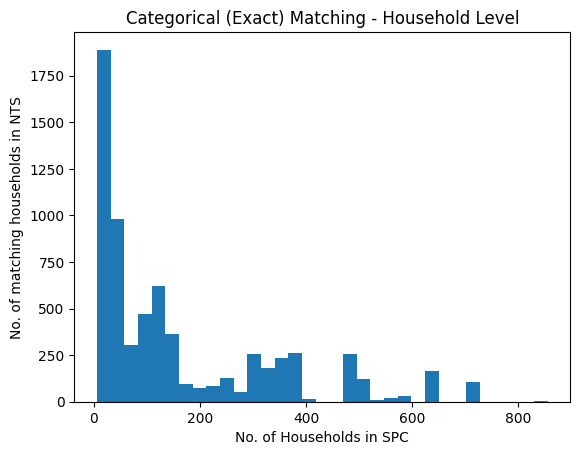

In [38]:
# Get the counts of each key
counts = [len(v) for v in matches_hh_level.values()]

# Create the histogram
plt.hist(counts, bins='auto')  # 'auto' automatically determines the number of bins

plt.title('Categorical (Exact) Matching - Household Level')
plt.xlabel('No. of Households in SPC')
plt.ylabel('No. of matching households in NTS')

plt.show()

Number of unmatched households

In [39]:
# no. of keys where value is na
na_count = sum([1 for v in matches_hh_level.values() if pd.isna(v).all()])


print(na_count, "households in the SPC had no match")
print(round((na_count / len(matches_hh_level)) * 100, 1), "% of households in the SPC had no match")



27 households in the SPC had no match
0.4 % of households in the SPC had no match


In [40]:
# print the 6th key, value in the matches_hh_level dictionary
print(list(matches_hh_level.items())[90])

('E02002183_0091', [2019001902.0, 2019004108.0, 2019001719.0, 2019001119.0, 2019001148.0, 2019003240.0, 2019002767.0, 2019002775.0, 2019005597.0, 2019002770.0, 2019006462.0, 2019004196.0, 2019004191.0, 2019004197.0, 2019000839.0, 2019000350.0, 2019000855.0, 2019001091.0, 2019004177.0, 2019005612.0, 2019001816.0, 2019003329.0, 2019002919.0, 2019005553.0, 2019002980.0, 2019001210.0, 2019001782.0, 2019001788.0, 2019001909.0, 2019000589.0, 2019002368.0, 2019002369.0, 2019002374.0, 2019002392.0, 2019002712.0, 2019002711.0, 2019001066.0, 2019001268.0, 2019003385.0, 2019000244.0, 2019003384.0, 2019001373.0, 2019001371.0, 2019006568.0, 2019000491.0, 2019000187.0, 2019003333.0, 2019002952.0, 2019000199.0, 2019004997.0, 2019005185.0, 2019005914.0, 2019001437.0, 2019004547.0, 2019006080.0, 2019006090.0, 2019005020.0, 2019005024.0, 2019000088.0, 2019000762.0, 2019000655.0, 2019000661.0, 2019004035.0, 2019000660.0, 2019005342.0, 2019005501.0, 2019002739.0, 2019001255.0, 2019001246.0, 2019004776.0, 

In [41]:
## add matches_hh_level as a column in spc_edited
spc_edited['nts_hh_id'] = spc_edited['hid'].map(matches_hh_level)

spc_edited.head(5)

,id,household,pid_hs,msoa11cd,oa11cd,members,sic1d2007,sic2d2007,pwkstat,salary_yearly,salary_hourly,hid,accommodation_type,communal_type,num_rooms,central_heat,tenure,num_cars,sex,age_years,ethnicity,nssec8,salary_yearly_hh,salary_yearly_hh_cat,is_adult,num_adults,is_child,num_children,is_pension_age,num_pension_age,pwkstat_FT_hh,pwkstat_PT_hh,pwkstat_NTS_match,OA11CD,RUC11,RUC11CD,Settlement2011EW_B03ID_spc,Settlement2011EW_B04ID_spc,Settlement2011EW_B03ID_spc_CD,Settlement2011EW_B04ID_spc_CD,tenure_spc_for_matching,nts_hh_id
0,0,0,2905399,E02002183,E00053954,[0],J,58.0,6,NaN,NaN,E02002183_0001,1.0,NaN,2.0,True,2.0,2,1,86,1,1.0,0.000000,1,1,1,0,0,1,1,0,0,1,E00053954,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004064.0, 2019002914.0, 2019002027.0, 201..."
1,1,1,2905308,E02002183,E00053953,"[1, 2]",C,25.0,6,NaN,NaN,E02002183_0002,3.0,NaN,6.0,True,2.0,2,1,74,3,1.0,0.000000,1,1,2,0,0,1,2,0,0,1,E00053953,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004130.0, 2019004126.0, 2019004144.0, 201..."
2,2,1,2907681,E02002183,E00053953,"[1, 2]",P,85.0,6,NaN,NaN,E02002183_0002,3.0,NaN,6.0,True,2.0,2,2,68,1,1.0,0.000000,1,1,2,0,0,1,2,0,0,1,E00053953,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004130.0, 2019004126.0, 2019004144.0, 201..."
3,3,2,2902817,E02002183,E00053689,"[3, 4]",C,31.0,1,32857.859375,14.360952,E02002183_0003,3.0,NaN,6.0,True,2.0,1,1,27,1,4.0,51020.310547,3,1,2,0,0,0,0,2,0,6,E00053689,Rural town and fringe,D1,Rural,Rural Town and Fringe,2,3,1.0,"[2019001219.0, 2019001010.0, 2019000952.0, 201..."
4,4,2,2900884,E02002183,E00053689,"[3, 4]",J,62.0,1,18162.451172,9.439944,E02002183_0003,3.0,NaN,6.0,True,2.0,1,2,26,1,4.0,51020.310547,3,1,2,0,0,0,0,2,0,6,E00053689,Rural town and fringe,D1,Rural,Rural Town and Fringe,2,3,1.0,"[2019001219.0, 2019001010.0, 2019000952.0, 201..."


### Random Sampling from matched households

In categorical matching, many households in the SPC are matched to more than 1 household in the NTS. Which household to choose? We do random sampling

In [42]:
# for each key in the dictionary, sample 1 of the values associated with it and store it in a new dictionary

'''
- iterate over each key-value pair in the matches_hh_result dictionary.
- For each key-value pair, use np.random.choice(value) to randomly select
one item from the list of values associated with the current key.
- create a new dictionary hid_to_HouseholdID_sample where each key from the
original dictionary is associated with one randomly selected value from the
original list of values.

'''
matches_hh_level_sample = {key: np.random.choice(value) for key, value in matches_hh_level.items()}

# remove items in list where value is nan
matches_hh_level_sample = {key: value for key, value in matches_hh_level_sample.items() if not pd.isna(value)}


In [43]:
print(list(matches_hh_level_sample.items())[568])

('E02002183_0571', 2019004347.0)


Multiple matches in case we want to try stochastic runs

In [44]:
# same logic as cell above, but repeat it multiple times and store each result as a separate dictionary in a list
matches_hh_level_sample_list = [{key: np.random.choice(value) for key, value in matches_hh_level.items()} for i in range(100)]

#matches_hh_level_sample_list

Save results

In [ ]:
# random sample
with open(get_interim_path("matches_hh_level_categorical_random_sample.pkl"), 'wb') as f:
    pkl.dump(matches_hh_level_sample, f)

# multiple random samples
with open(get_interim_path('matches_hh_level_categorical_random_sample_multiple.pkl'), 'wb') as f:
    pkl.dump(matches_hh_level_sample_list, f)

Do the same at the df level. Add nts_hh_id_sample column to the spc df

In [ ]:
# # for each hid in spc_edited, sample a value from the nts_hh_id col.
# spc_edited['nts_hh_id_sample'] = spc_edited['nts_hh_id'].apply(lambda x: np.random.choice(x) if x is not np.nan else np.nan)
# # All rows with the same 'hid' should have the same value for 'nts_hh_id_sample'. Group by hid and assign the first value to all rows in the group
# spc_edited['nts_hh_id_sample'] = spc_edited.groupby('hid')['nts_hh_id_sample'].transform('first')

# spc_edited.head(10)

## Step 4: Matching at Individual Level

1) Prepare columns for matching - they should all be numerical
    a) age_years in the SPC -> Convert from actual age to age brackets from the dictionary
2) Filter to specific household
3) Nearest neighbor merge without replacement (edit while function below)



In [ ]:
nts_individuals.head()

Create an 'age' column in the SPC that matches the NTS categories

In [ ]:
# create a dictionary for reference on how the labels for "Age_B04ID" match the actual age brackets

# dict_nts_ind_age = {-10: 'DEAD',
#                     -8: 'NA',
#                     1: '0-4',
#                     2: '5-10',
#                     3: '11-16',
#                     4: '17-20',
#                     5: '21-29',
#                     6: '30-39',
#                     7: '40-49',
#                     8: '50-59',
#                     9: '60+'
#                     }


# Define the bins and labels based on dict_nts_ind_age
bins = [0, 4, 10, 16, 20, 29, 39, 49, 59, np.inf]
labels = [1, 2, 3, 4, 5, 6, 7, 8, 9]

# Create a new column in spc_edited that maps the age_years to the keys of dict_nts_ind_age
spc_edited['age_group'] = (pd.cut(spc_edited['age_years'], bins=bins, labels=labels)
                     .astype('int')
                     .fillna(-8))

In [ ]:
# rename nts columns in preparation for matching

nts_individuals.rename(columns={'Age_B04ID': 'age_group', 'Sex_B01ID': 'sex'}, inplace=True)

PSM matching using internal match_individuals function

In [ ]:
matches_ind = match_individuals(
    df1 = spc_edited,
    df2 = nts_individuals,
    matching_columns = ['age_group', 'sex'],
    df1_id = 'hid',
    df2_id = 'HouseholdID',
    matches_hh = matches_hh_level_sample,
    show_progress = False)

#matches_ind

In [ ]:
import itertools

# Output the first n items of the dictionary
dict(itertools.islice(matches_ind.items(), 10))

In [ ]:
# Add matches_ind values to spc_edited using map
spc_edited['nts_ind_id'] = spc_edited.index.map(matches_ind)

# add the nts_individuals.IndividualID to spc_edit. The current nts_ind_id is the row index of nts_individuals
spc_edited['nts_ind_id'] = spc_edited['nts_ind_id'].map(nts_individuals['IndividualID'])


In [ ]:
spc_edited.head(5)

### Check that matching is working as intended

In [ ]:
#ids = [99, 100, 101, 102]
ids = [109, 110, 111, 112, 113, 114]


spc_rows = []
nts_rows = []

for id in ids:
    # get spc and nts values for position id
    spc_ind = list(matches_ind.keys())[id]
    nts_ind = matches_ind[list(matches_ind.keys())[id]]

    # get rows from spc and nts dfs that match spc_ind and nts_ind
    spc_row = spc_edited.loc[spc_ind]
    nts_row = nts_individuals.loc[nts_ind]

    # convert to df and append
    spc_rows.append(spc_row.to_frame().transpose())
    nts_rows.append(nts_row.to_frame().transpose())
# convert individual dfs to one df
spc_rows_df = pd.concat(spc_rows)
nts_rows_df = pd.concat(nts_rows)


spc_rows_df


In [ ]:
from IPython.display import display

display(spc_rows_df[['id', 'household', 'pwkstat', 'salary_yearly', 'salary_hourly', 'hid',
       'tenure', 'num_cars', 'sex', 'age_years','age_group', 'nssec8', 'salary_yearly_hh',
       'salary_yearly_hh_cat', 'is_adult','is_child', 'is_pension_age','pwkstat_FT_hh', 'pwkstat_PT_hh',
       'pwkstat_NTS_match', 'Settlement2011EW_B03ID_spc',
       'Settlement2011EW_B04ID_spc', 'Settlement2011EW_B03ID_spc_CD', 'Settlement2011EW_B04ID_spc_CD']])

display(nts_rows_df[['IndividualID', 'HouseholdID', 'Age_B01ID', 'age_group', 'sex','OfPenAge_B01ID', 'IndIncome2002_B02ID']])

### Match on multiple samples

In household level matching, some households in the SPC are matched to multiple households in the NTS. To have 1:1 match between the SPC and NTS, we randomly sample from the list of matches

The random sample produces different results each time. In `matches_hh_level_sample_list` we did many iterations of random sampling to produce multiple results of household matching, and saved the output in a list of dictionaries. 

Here, we iterate over the list and do individual matching for each item. The output is a list of n dictionaries, each of which could be used as a synthetic population matched to the NTS

In [ ]:
# iterate over all items in the matches_hh_level_sample_list and apply the match_individuals function to each

matches_list_of_dict = []
for i in trange(len(matches_hh_level_sample_list)):
    # apply match_individuals function to each item in the list
    matches_ind = match_individuals(
        df1 = spc_edited,
        df2 = nts_individuals,
        matching_columns = ['age_group', 'sex'],
        df1_id = 'hid',
        df2_id = 'HouseholdID',
        matches_hh = matches_hh_level_sample_list[i],
        show_progress= False)

    matches_list_of_dict.append(matches_ind)

Save the results of individual matching

In [ ]:
# random sample
with open(get_interim_path("matches_ind_level_categorical_random_sample.pkl"), 'wb') as f:
    pkl.dump(matches_ind, f)

# multiple random samples
with open(get_interim_path('matches_ind_level_categorical_random_sample_multiple.pkl'), 'wb') as f:
    pkl.dump(matches_list_of_dict, f)



### Add trip data 


In [ ]:
nts_trips.head(10)

Rename columns and map actual modes and trip purposes to the trip table. 

Code taken from: https://github.com/arup-group/pam/blob/main/examples/07_travel_survey_to_matsim.ipynb

In [ ]:
nts_trips = nts_trips.rename(
    columns={  # rename data
        "JourSeq": "seq",
        "TripOrigGOR_B02ID": "ozone",
        "TripDestGOR_B02ID": "dzone",
        "TripPurpFrom_B01ID": "oact",
        "TripPurpTo_B01ID": "dact",
        "MainMode_B04ID": "mode",
        "TripStart": "tst",
        "TripEnd": "tet",
    }
)

nts_trips.head(10)

In [ ]:
mode_mapping = {
    1: "walk",
    2: "bike",
    3: "car",  #'Car/van driver'
    4: "car",  #'Car/van driver'
    5: "motorcycle",  #'Motorcycle',
    6: "car",  #'Other private transport',
    7: "pt",  # Bus in London',
    8: "pt",  #'Other local bus',
    9: "pt",  #'Non-local bus',
    10: "pt",  #'London Underground',
    11: "pt",  #'Surface Rail',
    12: "car",  #'Taxi/minicab',
    13: "pt",  #'Other public transport',
    -10: "DEAD",
    -8: "NA",
}

purp_mapping = {
    1: "work",
    2: "work",  #'In course of work',
    3: "education",
    4: "shop",  #'Food shopping',
    5: "shop",  #'Non food shopping',
    6: "medical",  #'Personal business medical',
    7: "other",  #'Personal business eat/drink',
    8: "other",  #'Personal business other',
    9: "other",  #'Eat/drink with friends',
    10: "visit",  #'Visit friends',
    11: "other",  #'Other social',
    12: "other",  #'Entertain/ public activity',
    13: "other",  #'Sport: participate',
    14: "home",  #'Holiday: base',
    15: "other",  #'Day trip/just walk',
    16: "other",  #'Other non-escort',
    17: "escort",  #'Escort home',
    18: "escort",  #'Escort work',
    19: "escort",  #'Escort in course of work',
    20: "escort",  #'Escort education',
    21: "escort",  #'Escort shopping/personal business',
    22: "escort",  #'Other escort',
    23: "home",  #'Home',
    -10: "DEAD",
    -8: "NA",
}


nts_trips["mode"] = nts_trips["mode"].map(mode_mapping)

nts_trips["oact"] = nts_trips["oact"].map(purp_mapping)

nts_trips["dact"] = nts_trips["dact"].map(purp_mapping)

In [ ]:
nts_trips.head(10)

In [ ]:
# create an independant copy of spc_edited
spc_edited_copy = spc_edited.copy()

# replace non-finite values with a default value
spc_edited_copy['nts_ind_id'].fillna(-1, inplace=True)
# convert the nts_ind_id column to int for merging
spc_edited_copy['nts_ind_id'] = spc_edited_copy['nts_ind_id'].astype(int)

# merge the copy with nts_trips using IndividualID
spc_edited_copy = spc_edited_copy.merge(nts_trips,
                                        left_on='nts_ind_id', right_on='IndividualID',
                                        how='left')

In [ ]:
spc_edited_copy.head(10)

In [ ]:
# save the file as a parquet file
spc_edited_copy.to_parquet(get_interim_path('spc_with_nts_trips.parquet'))